In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 ## sklearn libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import os
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv('personality_dataset.csv')
data.head

<bound method NDFrame.head of       Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0                  4.0         No                      4.0            6.0   
1                  9.0        Yes                      0.0            0.0   
2                  9.0        Yes                      1.0            2.0   
3                  0.0         No                      6.0            7.0   
4                  3.0         No                      9.0            4.0   
...                ...        ...                      ...            ...   
2895               3.0         No                      7.0            6.0   
2896               3.0         No                      8.0            3.0   
2897               4.0        Yes                      1.0            1.0   
2898              11.0        Yes                      1.0            NaN   
2899               3.0         No                      6.0            6.0   

     Drained_after_socializing  Friends_circl

In [4]:
print('Dataset Shape', data.shape)
print("\nDataset Info: ")
print(data.info())
print('\nMissing Values: ')
print(data.isnull().sum())

Dataset Shape (2900, 8)

Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

Missing Values: 
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency           

In [5]:
# Defining numeric and Categorical Columns
numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
categorical_columns = ['Stage_fear', 'Drained_after_socializing']
target_column = 'Personality'

In [6]:
# verifying categorical values
for col in categorical_columns:
    print(f"\nUnique values in {col}: ")
    print(data[col].value_counts(dropna=False))


Unique values in Stage_fear: 
Stage_fear
No     1417
Yes    1410
NaN      73
Name: count, dtype: int64

Unique values in Drained_after_socializing: 
Drained_after_socializing
No     1441
Yes    1407
NaN      52
Name: count, dtype: int64


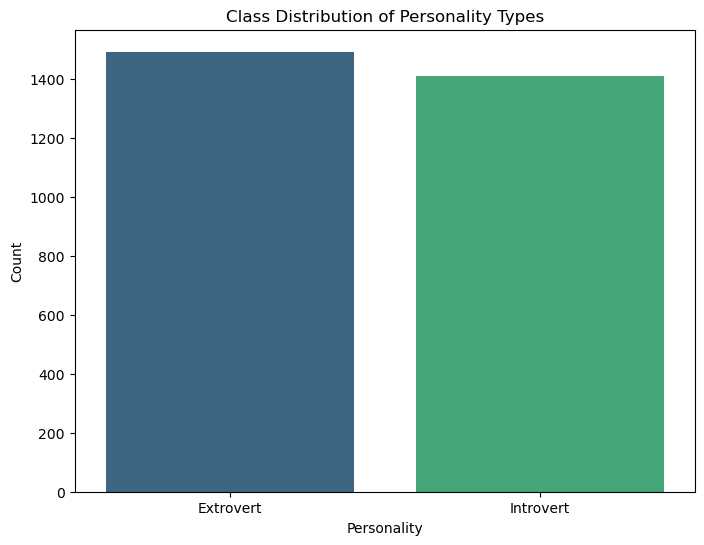

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(x = target_column, palette='viridis',data = data)
plt.title("Class Distribution of Personality Types")
plt.xlabel("Personality")
plt.ylabel("Count")
plt.show()

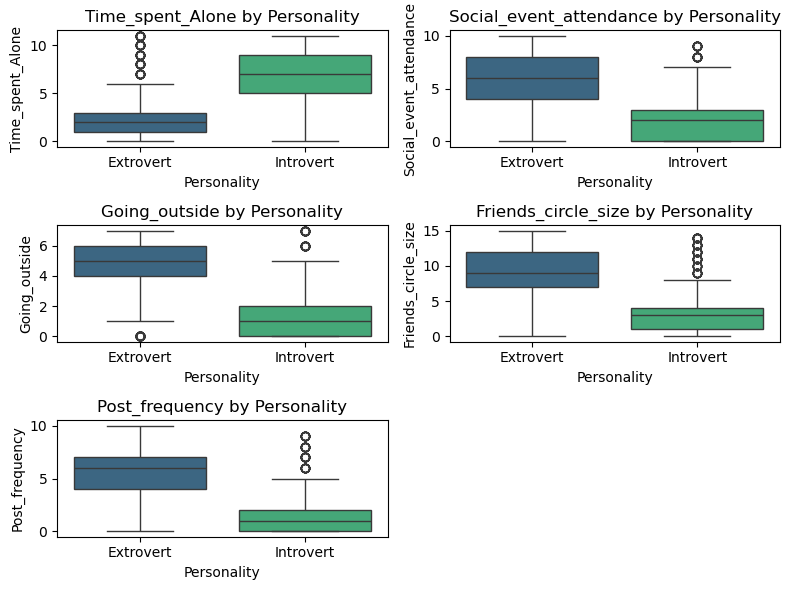

In [8]:
 #Numeric feature distributions by class
plt.figure(figsize=(8, 6))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=target_column, y=col, data=data,palette='viridis')
    plt.title(f'{col} by Personality')
plt.tight_layout()
#plt.savefig('/kaggle/working/box_plots.png')
plt.show()

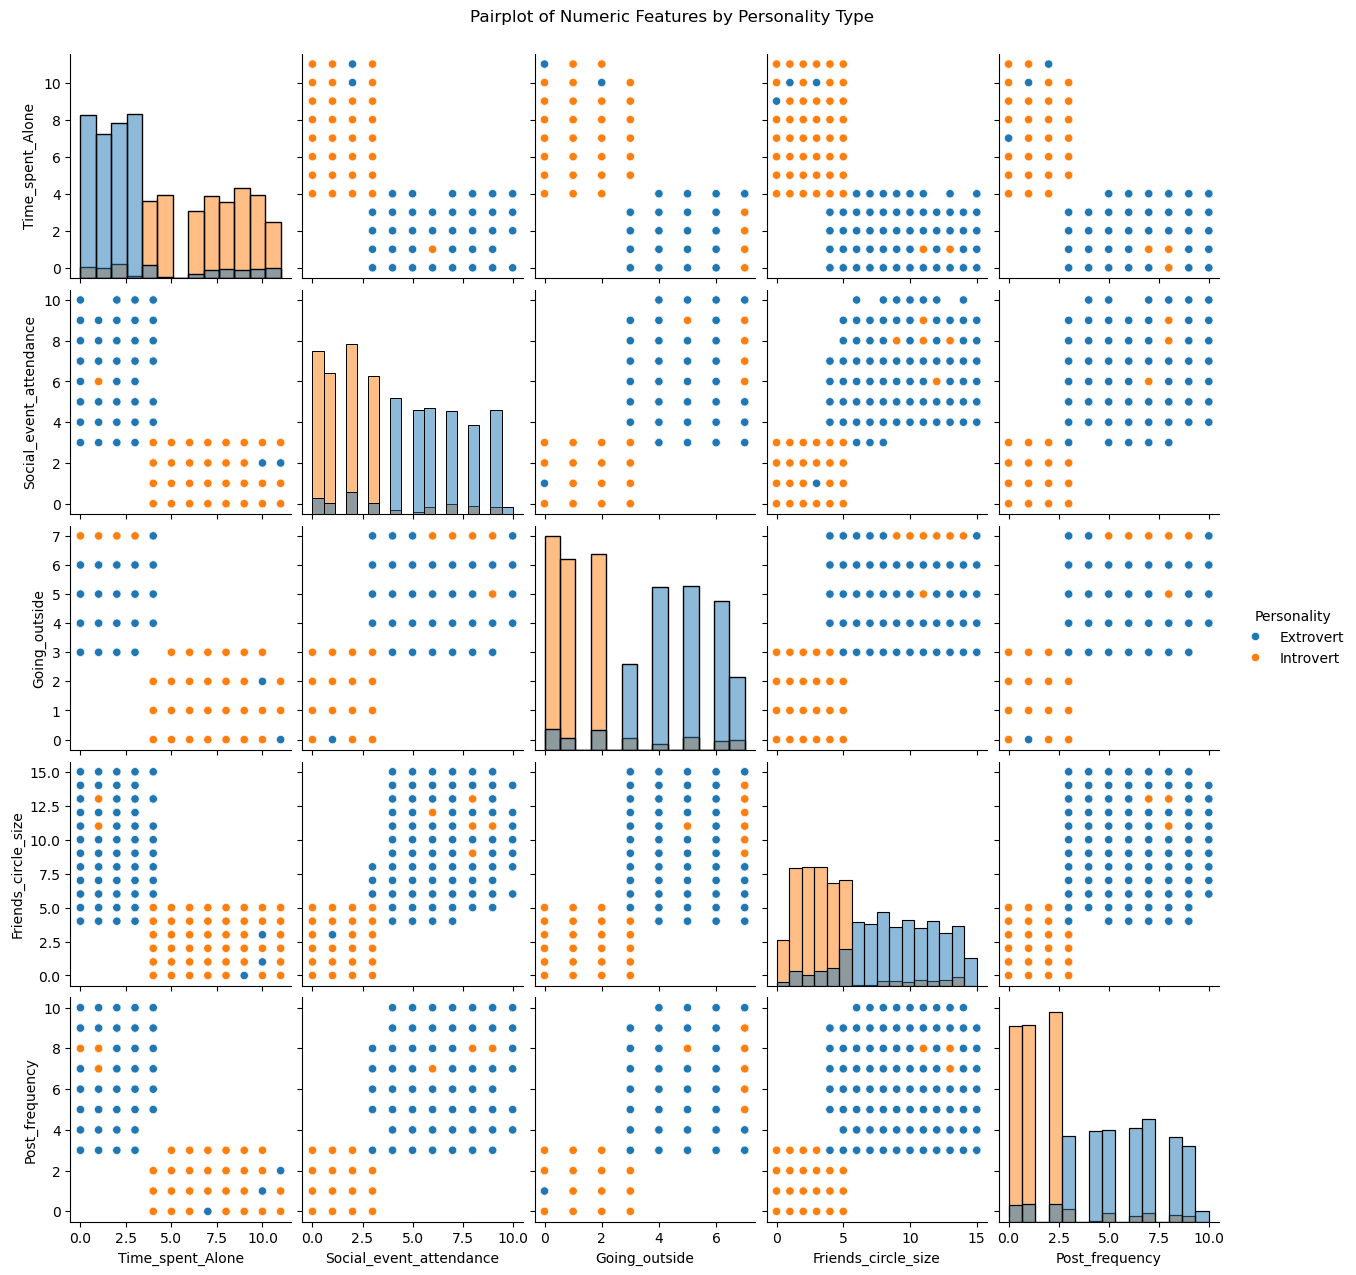

In [9]:
sns.pairplot(data[numeric_columns + [target_column]], hue=target_column, diag_kind='hist')
plt.suptitle('Pairplot of Numeric Features by Personality Type', y=1.02)
plt.show()

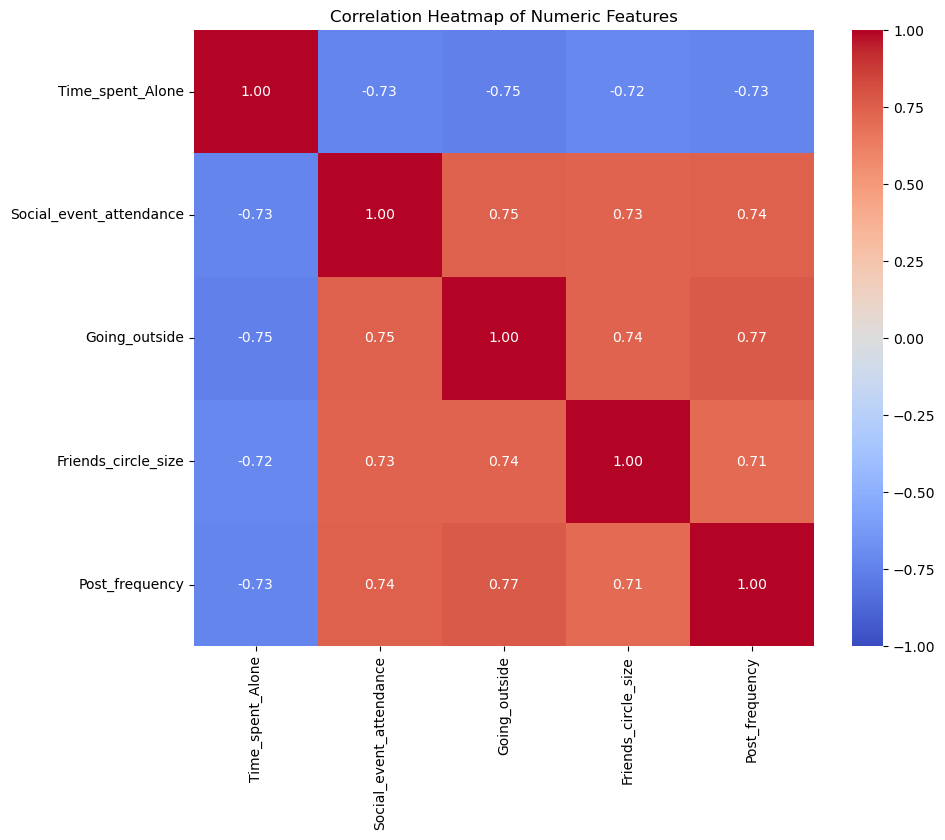

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [11]:
# Data Preprocessing
le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])
print(f"Encoded classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Handling missing values
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

# Categorical Features
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

# Encoding Categorical Features
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Updating Features
encoded_columns = [col for col in data.columns if col != target_column]

# Cap outliers
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

Encoded classes: {'Extrovert': 0, 'Introvert': 1}


In [21]:
# Train Test Split

X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state=42)

In [13]:
# Handle class imbalance with SMOTE

smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Feature Engineering

In [14]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
 
X_train['Alone_to_Social_Ratio'] = X_train['Time_spent_Alone'] / (X_train['Social_event_attendance'] + 1)
X_test['Alone_to_Social_Ratio'] = X_test['Time_spent_Alone'] / (X_test['Social_event_attendance'] + 1)
X_train['Social_Comfort_Index'] = (X_train['Friends_circle_size'] + X_train['Post_frequency'] - X_train['Stage_fear_Yes']) / 3
X_test['Social_Comfort_Index'] = (X_test['Friends_circle_size'] + X_test['Post_frequency'] - X_test['Stage_fear_Yes']) / 3
X_train['Social_Overload'] = X_train['Drained_after_socializing_Yes'] * X_train['Social_event_attendance']
X_test['Social_Overload'] = X_test['Drained_after_socializing_Yes'] * X_test['Social_event_attendance']

# Binned features
X_train['Time_spent_Alone_Binned'] = pd.qcut(X_train['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_test['Time_spent_Alone_Binned'] = pd.qcut(X_test['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_train = pd.get_dummies(X_train, columns=['Time_spent_Alone_Binned'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Time_spent_Alone_Binned'], drop_first=True)

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_features_train = poly.fit_transform(X_train[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_features_test = poly.transform(X_test[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_feature_names = poly.get_feature_names_out(['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size'])
X_train[poly_feature_names] = poly_features_train
X_test[poly_feature_names] = poly_features_test

# Update scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training and Evaluation

In [15]:
models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True,
        'params': {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'liblinear']}
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True,
        'params': {'C': np.logspace(-3, 3, 20), 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1]}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True,
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=42),
        'use_scaled': False,
        'params': {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    },
    'xgb': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.8]}
    }
}

In [16]:
# Hyperparameter Tuning

results = []
for model_name, mp in models.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], n_iter=20, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
    X_train_current = X_train_scaled if mp['use_scaled'] else X_train
    clf.fit(X_train_current, y_train)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [18]:
# Model Performance
df_results = pd.DataFrame(results)
print("\n Model Performance (Cross-Validation F1-Weighted Scores): ")
print(df_results)


 Model Performance (Cross-Validation F1-Weighted Scores): 
      model  best_score                                        best_params
0  logistic    0.938387    {'solver': 'lbfgs', 'C': 0.0006951927961775605}
1       svm    0.938387  {'kernel': 'rbf', 'gamma': 0.1, 'C': 12.742749...
2        rf    0.938387  {'n_estimators': 100, 'min_samples_split': 5, ...
3        gb    0.936709  {'n_estimators': 100, 'max_depth': 3, 'learnin...
4       knn    0.937129           {'weights': 'uniform', 'n_neighbors': 7}
5        dt    0.932516           {'min_samples_split': 2, 'max_depth': 5}
6       xgb    0.937129  {'subsample': 0.8, 'n_estimators': 150, 'max_d...


In [19]:
# Stacking Ensemble

estimators = [
    ('rf', RandomForestClassifier(**df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0], random_state=42)),
    ('gb', GradientBoostingClassifier(**df_results.loc[df_results['model'] == 'gb']['best_params'].iloc[0], random_state=42)),
    ('xgb', XGBClassifier(**df_results.loc[df_results['model'] == 'xgb']['best_params'].iloc[0], random_state=42, eval_metric='logloss')),
    ('svm', SVC(**df_results.loc[df_results['model'] == 'svm']['best_params'].iloc[0], probability=True))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1)
stacking_model.fit(X_train_scaled, y_train)

# Cross-validation for stacking model
stacking_scores = cross_val_score(stacking_model, X_train_scaled, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
print(f"\nStacking Model Cross-Validation F1-Weighted Score: {stacking_scores.mean():.3f} ± {stacking_scores.std():.3f}")


Stacking Model Cross-Validation F1-Weighted Score: 0.938 ± 0.002


In [23]:
# Evaluate on test set

y_pred = stacking_model.predict(X_test_scaled)
print("\n Stacking Model Classification Report:")
print(classification_report(y_test, y_pred,target_names=le.classes_))


 Stacking Model Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



<Figure size 800x600 with 0 Axes>

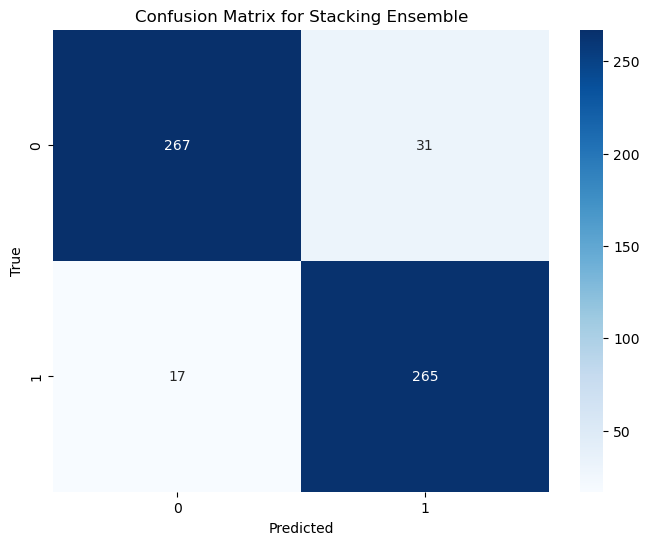

In [25]:
# Cofusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd', cmap = 'Blues')
plt.title("Confusion Matrix for Stacking Ensemble")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

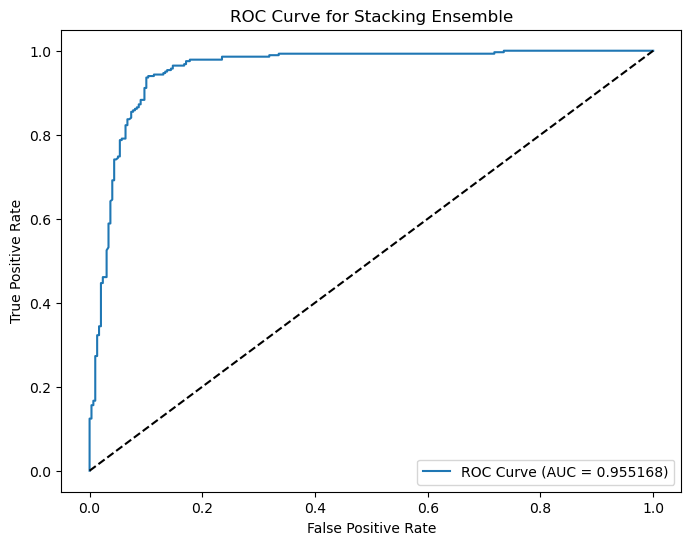

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = roc_auc_score(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {roc_auc:2f})')
plt.plot([0,1], [0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve for Stacking Ensemble')
plt.legend()
plt.show()


Feature Importance (Random Forest):
                         Feature  Importance
6  Drained_after_socializing_Yes    0.264044
5                 Stage_fear_Yes    0.200015
1        Social_event_attendance    0.152203
0               Time_spent_Alone    0.137065
4                 Post_frequency    0.113769
2                  Going_outside    0.104577
3            Friends_circle_size    0.028327


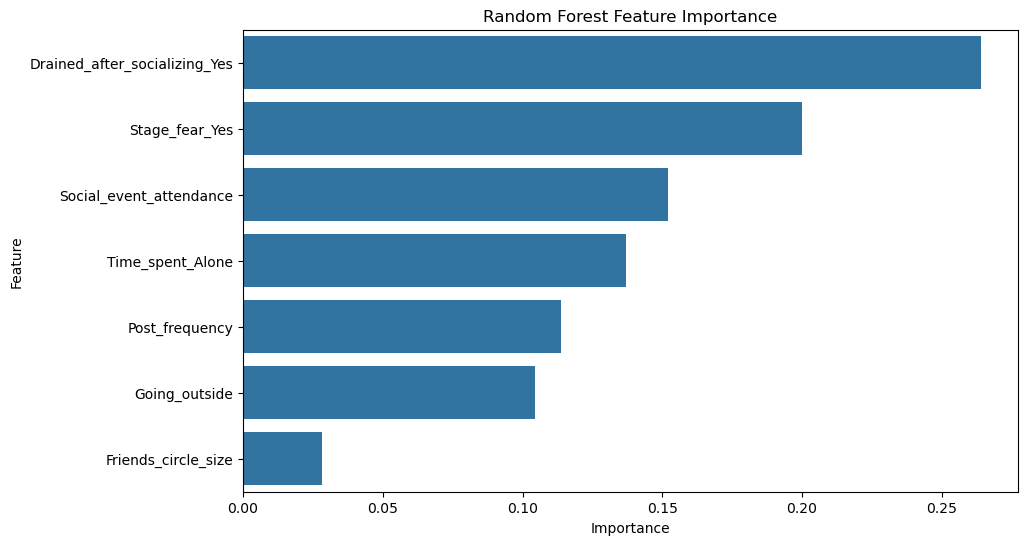

In [29]:
# Random Forest feature importance
rf_model = RandomForestClassifier(**df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0], random_state=42)
rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Feature importance bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

<Figure size 1000x600 with 0 Axes>

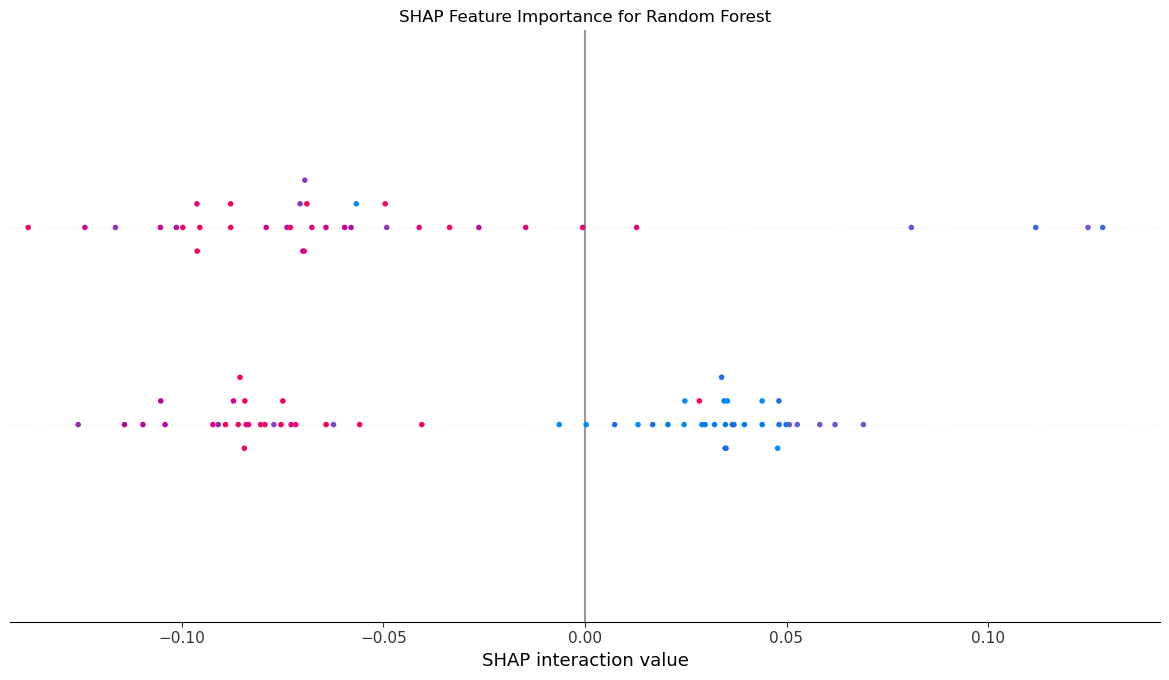

In [42]:
# SHAP values (using a sample for efficiency)
X_test_sample = X_test.sample(frac=0.1, random_state=42)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test.columns, show = False)
plt.title('SHAP Feature Importance for Random Forest')
plt.show()


In [43]:
# SHAP summary for both classes
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values[1], X_test_sample, feature_names=X_test.columns, show=False)
# plt.title('SHAP Values for Extrovert Class')
# plt.show()